In [1]:
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/usr/local/lib/python3.7/site-packages/')
 
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from tqdm import tqdm
# from sklearn.ensemble import RandomForestRegressor
# from boruta import BorutaPy

%matplotlib inline

In [2]:
model_ki = CatBoostRegressor() 
model_ki.load_model('../models/ki_all_catboost_reg_mae_0.670_0.721')
model_ki.get_params()

{'loss_function': 'MAE',
 'use_best_model': True,
 'od_wait': 100,
 'verbose': 0,
 'iterations': 20000,
 'l2_leaf_reg': 1,
 'task_type': 'GPU',
 'random_seed': 42,
 'learning_rate': 0.1}

In [3]:
data_df = pd.read_csv('../data/2020-06_Enamine_screening_compounds_in-stock_SMILES.smiles', usecols=[0], sep='\s+')
data_df.shape

(2761292, 1)

In [7]:
train_df = pd.read_csv('../data/fasta-smiles-ki-catboost/fasta_pbm_physchem_smiles_ecfp4_ki_with_strings.csv')
train_df.shape

(417047, 2268)

In [20]:
ligand_cols = list(train_df.filter(like='Ligand ECFP4').columns)
ligand_cols.extend(['FASTA', 'Ligand SMILES', 'Ki (nM)'])

In [8]:
human_thrombin_fasta = 'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE'


In [24]:
human_thrombin_fasta_features = train_df[train_df.FASTA == human_thrombin_fasta].drop(columns=ligand_cols)

In [34]:
human_thrombin_fasta_features.head()

CV0   CV1   CV2   CV3   CV4  CV5   CV6   CV7   CV8   CV9  ...  \
4423  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4424  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4425  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4426  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4427  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   

      _HydrophobicityD2001  _HydrophobicityD2025  _HydrophobicityD2050  \
4423                 0.322                23.473                45.177   
4424                 0.322                23.473                45.177   
4425                 0.322                23.473                45.177   
4426                 0.322                23.473                45.177   
4427                 0.322                23.473                45.177   

      _HydrophobicityD2075  _HydrophobicityD2100  _HydrophobicityD3001  \
4423                72.508                99.839                 0.161   
4424                72.508                99.839                 0.161   
4425                72.508                99.839                 0.161   
4426                72.508                99.839                 0.161   
4427                72.508                99.839                 0.161   

      _HydrophobicityD3025  _HydrophobicityD3050  _HydrophobicityD3075  \
4423                25.241                54.823                76.206   
4424                25.241                54.823                76.206   
4425                25.241                54.823                76.206   
4426                25.241                54.823                76.206   
4427                25.241                54.823                76.206   

      _HydrophobicityD3100  
4423                99.678  
4424                99.678  
4425                99.678  
4426                99.678  
4427                99.678  

[5 rows x 217 columns]

In [31]:
human_thrombin_fasta_features.values[0].shape

(217,)

In [48]:
human_thrombin_fasta_features_list = human_thrombin_fasta_features.values[0].tolist()

In [52]:
def make_inference(row):
    try:
        m = Chem.MolFromSmiles(row)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2,invariants=[1]*m.GetNumAtoms())
        array = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        features = human_thrombin_fasta_features_list.copy()
        features.extend(array.tolist())
        pred = 10**model_ki.predict(features)
        return pred
    except Exception as e:
        print(e)
        return np.nan

In [ ]:
%%time

with open('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all', 'w') as results:
    for index, row in tqdm(data_df.iterrows()):
        pred = make_inference(row.smiles)
        results.write("{}, {}\n".format(row.smiles, pred))

2560659it [5:00:41, 160.18it/s]

# top 100

In [54]:
results_df = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all',
                         header=None,
                         low_memory=False,
                         names=['SMILES', 'Ki (nM)'])

In [55]:
results_df.head()

SMILES              Ki (nM)
0               CCC1(NC(=O)N(Cc2ccccc2)C1=O)c1ccccc1   1204.7174161008081
1        O=C(CSc1nnc(-c2cccs2)n1Cc1ccccc1)NCc1ccccc1   428.23638696344767
2                              CSc1nc2nc(C)cc(C)n2n1    7135.045189207444
3                           Cc1cc(C)n2nc(SCC#N)nc2n1   1920.5428472770936
4  FC(F)(F)c1cc(Cl)c(=O)n(CC(=O)N(Cc2ccccc2)Cc2cc...   268.05024812415246

In [56]:
results_df = results_df.dropna()
results_df.dtypes

SMILES     object
Ki (nM)    object
dtype: object

In [57]:
results_df['Ki (nM)'] = results_df['Ki (nM)'].astype(float)

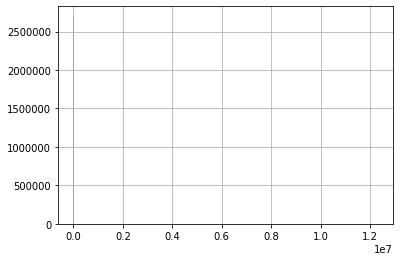

In [58]:
results_df['Ki (nM)'].hist(bins=1000)

In [59]:
results_df['Ki (nM)'].describe()

count    2.761269e+06
mean     2.749732e+03
std      2.362427e+04
min      2.153722e-01
25%      4.979843e+02
50%      1.157325e+03
75%      2.613304e+03
max      1.231126e+07
Name: Ki (nM), dtype: float64

In [60]:
top100 = results_df.nsmallest(100, 'Ki (nM)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6fce0ead0>]],
      dtype=object)

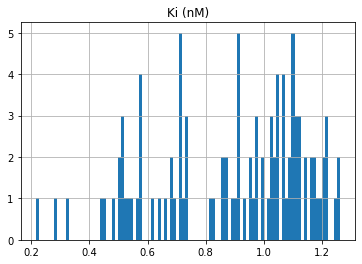

In [61]:
top100.hist(bins=100)

In [62]:
top100.head(50)

SMILES   Ki (nM)
585061   CN(CC(=O)Nc1c(C)n(C)n(-c2ccccc2)c1=O)S(=O)(=O)...  0.215372
500827   CN(CC(=O)OCC(=O)C(C#N)=C1Nc2ccccc2N1)S(=O)(=O)...  0.287161
1757006  COC1(CNC(=O)CN(C)S(=O)(=O)c2ccc(NC(C)=O)cc2)CCOC1  0.320589
369670                    CCCCC(=O)NS(=O)(=O)N(C)Cc1ccccc1  0.442056
1134687  CC1CN(CC(C)O1)C(C)(C)CNC(=O)CCCN(C)S(=O)(=O)c1...  0.447712
623454   COc1ccccc1CCNC(=O)CN(C)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.484905
2080373  CC1CN(CC(C)O1)C(=O)COC(=O)CN(C)S(=O)(=O)c1ccc(...  0.499184
761609          COc1ccccc1CN(C)S(=O)(=O)c1ccc(CNC(C)=O)cc1  0.506153
1170935       COC(=O)CCN(C)S(=O)(=O)NCCC(c1ccccc1)c1ccccc1  0.510357
174326   CCNC(=O)CN(C)S(=O)(=O)c1ccc(cc1)-c1ccc(NC(C)=O...  0.511878
123925      CN(Cc1ccccc1)S(=O)(=O)c1ccc(NC(=O)CCC(O)=O)cc1  0.514001
1264947     CCNC(=O)CNC(=O)CN(C)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.523010
2080623  CCOc1ccc(OCCOC(=O)CN(C)S(=O)(=O)c2ccc(NC(C)=O)...  0.534205
2236866  CCCn1c2ccccc2n(CCC(=O)NNC(=O)CN(C)S(=O)(=O)c2c...  0.545311
1205708           CCCN(C)S(=O)(=O)NC(=O)CCc1cn(C)c2ccccc12  0.568629
1501073  CN(CC(=O)NCC1(CC1)c1ccccc1)S(=O)(=O)c1ccc(NC(C...  0.571644
2733197     CCS(=O)(=O)N(C)CCCn1c(csc1=Nc1ccccc1)-c1cnccn1  0.571809
2300153             CN(Cc1ccccc1)S(=O)(=O)NC(=O)CCCn1cccn1  0.572707
501357   CCOC(=O)C1=C(COC(=O)CN(C)S(=O)(=O)c2ccc(NC(C)=...  0.573073
369671                     CCCC(=O)NS(=O)(=O)N(C)Cc1ccccc1  0.622933
1150729  CN(Cc1ccccc1)S(=O)(=O)c1ccc(NC(=O)Cc2ccc(NC(C)...  0.640122
2080214  CN(CC(=O)OCCOc1ccccc1C)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.660594
1029124           CN(Cc1sccc1C)S(=O)(=O)c1ccc(CCC(O)=O)cc1  0.681327
2531170           CN(Cc1ccoc1C)S(=O)(=O)c1ccc(OCC(O)=O)cc1  0.681327
2163542  CN(CC=C)S(=O)(=O)c1ccc(NCC(=O)NC2(CCCCCC2)C#N)cc1  0.696684
1167722  CCCOc1ccc2ccccc2c1CN(C)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.710793
18770             CN(Cc1ccccc1)S(=O)(=O)c1ccc(CCC(O)=O)cc1  0.717819
426707             CN(Cc1ccco1)S(=O)(=O)c1ccc(CCC(O)=O)cc1  0.717819
1027763            CN(Cc1cccs1)S(=O)(=O)c1ccc(CCC(O)=O)cc1  0.717819
2521717            CN(Cc1ccc(OCC(O)=O)cc1)S(=O)(=O)c1cccs1  0.717819
1888958  CN(CC(=O)OCC(=O)Nc1cccnc1Cl)S(=O)(=O)c1ccc(NC(...  0.720242
1333213           CC1CCCN(C1)S(=O)(=O)N(C)Cc1c(C)nc2sccn12  0.728891
748913   CN(Cc1ccc(cc1)C(=O)NN=C(CCC(O)=O)c1cccs1)S(=O)...  0.730544
2593928  CN(Cc1ccc(cc1)C(=O)N\N=C(\CCC(O)=O)c1cccs1)S(=...  0.730544
645655   CN(CC(=O)NN1C(=O)NC2(CCCCC2)C1=O)S(=O)(=O)c1cc...  0.812679
1030172              COC(=O)CCCN(C)S(=O)(=O)N1CC(C)OC(C)C1  0.830993
758801            CN(Cc1ccccc1F)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.861646
2152771          CN(Cc1ccccc1Cl)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.861646
671143   CN(CC(=O)NCCc1ccc(cc1)S(N)(=O)=O)S(=O)(=O)c1cc...  0.868295
1660266       COC(=O)CN(C)S(=O)(=O)C1CCCN(C1)C(=O)c1ccccc1  0.870622
700198   CN(CC(=O)NCc1ccc(nc1)-n1ccnc1C)S(=O)(=O)c1ccc(...  0.890179
2400161              CN(C)c1ncc(CN(C)S(=O)(=O)CC(Cl)=C)cn1  0.900724
499908   CN(CC(=O)OCC(=O)NCCc1ccccc1)S(=O)(=O)c1ccc(NC(...  0.913123
500817    CN(CC(=O)OCCOc1ccccc1)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.913123
579489    CN(CC(=O)NCCOc1ccccc1)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.913123
630397      CN(CC(=O)NCCc1cccs1)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.913123
2124184  CN(CC(=O)NCCCSc1ccccc1)S(=O)(=O)c1ccc(NC(C)=O)cc1  0.913123
808706           COC(=O)COc1ccc(cc1)S(=O)(=O)N(C)Cc1ccccn1  0.936770
2080335  CCc1cccc(C)c1NC(=O)COC(=O)CN(C)S(=O)(=O)c1ccc(...  0.949090
1994027  COc1ccc(cc1S(=O)(=O)N(C)Cc1ccccc1)C(=O)OCC(=O)...  0.957610

In [63]:
top100.to_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all.top100',
              index=None)

# 100 largest

In [64]:
top100largest = results_df.nlargest(100, 'Ki (nM)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6fcf2ec10>]],
      dtype=object)

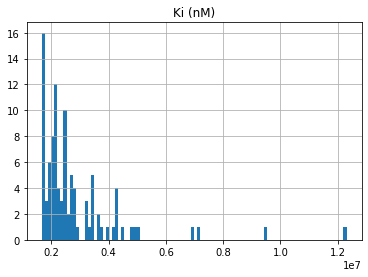

In [65]:
top100largest.hist(bins=100)

In [66]:
top100largest.head(50)

SMILES       Ki (nM)
1230770  COC(=O)c1c(CC(=O)N=c2sc3ccccc3n2C)[nH]c(C(C)=O...  1.231126e+07
2288749  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  9.517519e+06
828992   CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  7.120899e+06
832200   CCOC(=O)C=c1sc(=Cc2ccc(cc2)C#N)c(=O)n1CC(=O)NC...  6.886710e+06
2169069  CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  4.982472e+06
2288745  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.936689e+06
2097526    Cc1nn(CC(=O)N=c2sc3ccccc3n2C)c(C)c1[N+]([O-])=O  4.864711e+06
2288811  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.508168e+06
1347946  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  4.317653e+06
834107   COCC(C)NC(=O)Cn1c(=CC(=O)C(C)(C)C)sc(=Cc2ccc3c...  4.263599e+06
828971   CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  4.251782e+06
2287189  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CCOC)c1=NC(=O)C...  4.229293e+06
2285327  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  4.130849e+06
2288634  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.942082e+06
2285325  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(C(C)C)c1=NC(...  3.697531e+06
2355647     CC(C)(C)C(=O)C=c1[nH]c(=O)c(=Cc2cc3ccccc3o2)s1  3.645510e+06
2442866  NS(=O)(=O)c1ccc(NC(=O)CSC2=NNC(N2c2ccccc2)=C2C...  3.593011e+06
1628921  CCOC(=O)C=c1sc(=Cc2cc3ccccc3nc2O)c(=O)n1CC(=O)...  3.472222e+06
1339715  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.467283e+06
2289214  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  3.467283e+06
1839392            CCCn1c2ccccc2n(CC)c1=NC(=O)CC1COC(=O)C1  3.431850e+06
2168974  CCOC(=O)C=c1sc(=Cc2cc(OC)cc(OC)c2)c(=O)n1CC(=O...  3.390305e+06
2289185  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.316294e+06
2288650  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.242522e+06
2288818  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  3.237471e+06
2284780  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  3.216472e+06
2169074  CCN(CC)c1ccc(C=c2sc(=CC(=O)C(C)(C)C)n(CC(=O)NC...  2.942214e+06
1808640     Cn1[nH]c(cc1=NC(=O)Cn1cnc(n1)C#N)-c1ccc(Cl)cc1  2.830046e+06
2169302  COCC(C)NC(=O)Cn1c(=O)c(=Cc2ccc(Cl)cc2)sc1=CC(=...  2.811315e+06
576242         CC(=O)c1c(C)[nH]c(C(=O)N=c2sc3ccccc3n2C)c1C  2.808810e+06
2442873  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.767945e+06
1339593  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.735995e+06
2295897  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C2CCCCC2)c1=NC(...  2.714426e+06
2289199  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.714393e+06
1980186                   CCCn1c2ccccc2n(CC)c1=NC(=O)N(C)C  2.693865e+06
2289186  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.645356e+06
1272464      CC(SC1=NNC(N1c1ccccc1)=C1C=c2ccccc2=N1)C(N)=O  2.606440e+06
1970149              CCCn1c2ccccc2n(CC)c1=NC(=O)CN1CCSC1=O  2.530336e+06
1544232       CC1=NC(NN1c1ccc(F)cc1)=C(O)N=C1N=c2ccccc2=N1  2.513916e+06
2284786  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(C(C)C)c1=NC(...  2.482203e+06
828958   CCCC(C)NC(=O)Cn1c(=CC(=O)C(C)(C)C)sc(=Cc2ccc(C...  2.477612e+06
1342121  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.473159e+06
1938786  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.473159e+06
2295620  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.451192e+06
832159   CCOC(=O)C=c1sc(=Cc2c(C)cc(C)cc2C)c(=O)n1CC(=O)...  2.449483e+06
2285324  CCOCCCn1c2nc3ccccn3c(=O)c2cc(C(=O)OCC)c1=NC(=O...  2.429383e+06
2286934  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.419381e+06
2289179  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(CC(C)C)c1=NC(=O...  2.419381e+06
2285916  CCOC(=O)c1cc2c(nc3c(C)cccn3c2=O)n(CC(C)C)c1=NC...  2.337442e+06
2288717  CCOC(=O)c1cc2c(nc3ccccn3c2=O)n(C(C)C)c1=NC(=O)...  2.321402e+06

In [67]:
top100largest.to_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.all.top100largest',
              index=None)

# Intersection with thrombin results - top100

In [68]:
top100thrombin = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.top100')

In [73]:
set(top100thrombin.SMILES).intersection(set(top100.SMILES))

set()

# Intersection with thrombin results - top500

In [74]:
top500thrombin = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.top500')
set(top500thrombin.SMILES).intersection(set(results_df.nsmallest(500, 'Ki (nM)').SMILES))

{'CCCCn1c(nn(CCC(=O)Nc2c(C)cccc2CC)c1=S)-c1ccc(Cl)cc1',
 'CCn1c(nn(Cc2ccc(F)cc2C#N)c1=O)[C@H]1OCC[C@H]1c1ccccc1',
 'Cc1c(NC(=O)CSc2nc(C)cc(C)c2C#N)c(=O)n(-c2ccccc2)n1C',
 'Cc1cc(C)n(n1)-c1cccc(NC(=O)NCCCn2nc3CCCCn3c2=O)c1'}